## IBM Quantum Computers

아래의 사진들은 양자 컴퓨터의 외관과 내관입니다.

<div>
<img src="https://iqx-docs.quantum-computing.ibm.com/_images/sys-one2.jpg" width="500"/>
</div>

<div>
<img src="https://user-images.githubusercontent.com/529049/66485044-a292c600-ea97-11e9-9696-b3a6606458ba.jpg" width="500"/>
</div>

<div>
<img src="https://github.com/Qiskit/ibmq-device-information/raw/master/backends/yorktown/images/ibmqx2-labeled.png?raw=true" width="500"/>
</div>

그러면 우리는 이 양자 컴퓨터를 어떻게 사용할 수 있을까요?

<div>
<img src="https://iqx-docs.quantum-computing.ibm.com/_images/qiskit-nb.jpg" width="500"/>
</div>

<div>
<img src="https://iqx-docs.quantum-computing.ibm.com/_images/normal_queue_with_providers2.png" width="800"/>
</div>

이제 본격적으로 양자 컴퓨터를 이용해보도록 해요. 먼저 양자 컴퓨터에 입력할 코드를 짜는 과정에 대해서 살펴보고, 그 이후에 양자 컴퓨터에 코드를 전송하고 작동하여 출력받은 결과값을 보도록 하겠습니다. 여기서 살펴볼 양자 코드는 양자 위상 추정 알고리즘(quantum phase estimation algorithm)입니다.

## Import Package

저번 시간에 양자 컴퓨터를 각자 집에서 사용할 수 있도록 qiskit을 설치했을겁니다. 아래의 코드는 전체 패키지 중에서 오늘 사용할 명령어를 켜는 과정입니다.

In [2]:
#qiskit 이외의 패키지
import numpy as np
import math

#qiskit 패키지에서 사용할 명령어 
#회로를 구성하는데 사용하는 명령어
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
#IBM에서 제공하는 양자컴퓨터를 사용하는데 필요한 명령어
from qiskit import IBMQ, transpile, assemble
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

#결과값을 분석하기 위한 명령어
from qiskit.visualization import plot_histogram

## 양자 위상 추정 알고리즘 (quantum phase estimation algorithm)

양자역학에서 관측은 어떻게 이루어질까요? 아래의 그림은 스핀을 관측기로 관측하는 모습을 도식적으로 그린 그림입니다.

<div>
<img src="Von_Neumann_Measurement.png" width="500"/>
</div>

간단하게 측정 계기판과 스핀은 

$\begin{align}
\hat{H} := \frac{E}{2} \hat{p} \otimes \left(
\hat{\sigma}_0-\hat{\sigma}_z
\right)
=E \; \hat{p} \otimes \mathinner{\lvert{1}\rangle}\mathinner{\langle{1}\lvert}
\end{align}$

의 해밀토니안으로 서로 상호작용을 이루고 있는 상황을 가정합니다. 초기$(t=0)$에 측정 계기판의 양자상태는 위치 연산자 $\hat{x}$의 고유상태 $\mathinner{\lvert{x}\rangle}$, 스핀은 임의의 상태

$\begin{align}
\mathinner{\lvert{\psi}\rangle}:=\alpha\mathinner{\lvert{0}\rangle}+\beta\mathinner{\lvert{1}\rangle}
\end{align}$

로 준비하여 전체 공간에서의 초기상태는

$\begin{align}
\mathinner{\lvert{\Psi(0)}\rangle}:=\mathinner{\lvert{x}\rangle}\otimes\mathinner{\lvert{\psi}\rangle}
\end{align}$

로 나타내집니다. 측정 계기판은 위치의 기댓값 $\langle\hat{x}\rangle$을 관측하며, 여기서 위치 연산자 $\hat{x}$와 운동량 연산자$\hat{p}$와

$\begin{align}
\left[\hat{x},\hat{p}\right]=i\hbar
\end{align}$

의 관계를 이룹니다.

시간이 $t$만큼 흐른 이후에 상태는

$\begin{align}
\mathinner{\lvert{\Psi(t)}\rangle}&=\mathrm{exp}\left[\frac{i\hat{H}t}{\hbar}\right]\mathinner{\lvert{\Psi(0)}\rangle}\\
&=\mathrm{exp}\left[i\theta \hat{p} \otimes \mathinner{\lvert{1}\rangle}\mathinner{\langle{1}\lvert})\right]
(\mathinner{\lvert{x}\rangle}\otimes\mathinner{\lvert{\psi}\rangle})
\;\;;\;\;\theta=\frac{E t}{\hbar}.
\end{align}$

측정 계기판의 상태를 운동량 공간에서 표현하면

$\begin{align}
\mathinner{\lvert{\Psi(t)}\rangle}&=
\mathrm{exp}\left[i\theta \hat{p} \otimes \mathinner{\lvert{1}\rangle}\mathinner{\langle{1}\lvert})\right]
\left\{\sum_p\mathrm{exp}\left[ipx\right]\mathinner{\lvert{\tilde{p}}\rangle}
\otimes(\alpha\mathinner{\lvert{0}\rangle}+\beta\mathinner{\lvert{1}\rangle})\right\}\\
&=\mathrm{exp}\left[i\theta \hat{p} \otimes \mathinner{\lvert{1}\rangle}\mathinner{\langle{1}\lvert})\right]
\left\{\alpha\sum_p\mathrm{exp}\left[ipx\right]\mathinner{\lvert{\tilde{p}}\rangle}
\otimes\mathinner{\lvert{0}\rangle}+\beta\sum_p\mathrm{exp}\left[ipx\right]\mathinner{\lvert{\tilde{p}}\rangle}
\otimes\mathinner{\lvert{1}\rangle})\right\}\\
&=\alpha\sum_p\mathrm{exp}\left[ipx\right]\mathinner{\lvert{\tilde{p}}\rangle}
\otimes\mathinner{\lvert{0}\rangle}
+\beta\sum_p\mathrm{exp}\left[ip(x+\theta)\right]\mathinner{\lvert{\tilde{p}}\rangle}
\otimes\mathinner{\lvert{1}\rangle}.
\end{align}$

다시 측정 계기판의 상태를 위치 공간에서 나타내게 되면

$\begin{align}
\mathinner{\lvert{\Psi(t)}\rangle}=
\alpha\mathinner{\lvert{x}\rangle}
\otimes\mathinner{\lvert{0}\rangle}
+\beta\mathinner{\lvert{x+\theta}\rangle}
\otimes\mathinner{\lvert{1}\rangle}.
\end{align}$

시간 $t$ 만큼 지난 이후의 상태를 보면 만약 초기에 스핀이 0의 상태로 준비되었다면$(\alpha=1,\beta=0)$ 측정값은 $x$가 나오게 됩니다:

$\begin{align}
\mathinner{\langle\Psi(t)\lvert{}}\hat{x}\mathinner{\lvert{\Psi(t)}\rangle}=\mathinner{\langle x\lvert{}}\hat{x}\mathinner{\lvert{x}\rangle}
\otimes\mathinner{\langle 0}\mathinner{\lvert{0}\rangle}=x.
\end{align}$

그에 반해 초기에 스핀이 1의 상태로 준비되었다면$(\alpha=0,\beta=1)$ 측정값은 $x+\theta$로 처음과 다르게 이동된 값으로 나오게 됩니다:

$\begin{align}
\mathinner{\langle\Psi(t)\lvert{}}\hat{x}\mathinner{\lvert{\Psi(t)}\rangle}=\mathinner{\langle x+\theta\lvert{}}\hat{x}\mathinner{\lvert{x+\theta}\rangle}
\otimes\mathinner{\langle 1}\mathinner{\lvert{1}\rangle}=x+\theta.
\end{align}$

<div>
<img src="Ditection_Graph.png" width="600"/>
</div>

이 관측 방법을 이용하여 양자 회로로 구현한 알고리즘이 양자 위상 추정 알고리즘(quantum phase estimation algorithm)입니다.

<div>
<img src="https://qiskit.org/textbook/ch-algorithms/images/qpe_tex_qz.png" width="800"/>
</div>

1 구간에서는 관측하는 큐빗들을 푸리에 변환을 시행하고, 2 구간에서 관측하고 싶은 큐빗과 상호작용을 이루고, 3 구간에서 푸리에 역변환을 시행하고, 4 구간에서 관측을 행합니다. 이 때, 나오는 각각의 큐빗에 대한 관측값은 각 이진법 자릿수의 값이 됩니다. 

우리 예제에서는 
$U=\mathinner{\lvert{0}\rangle}\mathinner{\langle{0}\lvert}+e^{\frac{i\pi}{4}}\mathinner{\lvert{1}\rangle}\mathinner{\langle{1}\lvert}$와 그에 해당하는 고유상태 $\mathinner{\lvert{\psi}\rangle}=\mathinner{\lvert{1}\rangle}$으로 정의합니다. 이 때 고유값의 위상 $\theta$은 $\frac{1}{8}$이 됩니다. 

qiskit을 이용하여 이 회로를 짜보자.

In [3]:
#4개의 큐빗과 3개의 고전 비트로 이루어진 회로 생성
qpe = QuantumCircuit(4, 3)
#q(3)에 x 게이트 연결
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

In [4]:
#q(1-1)부터 q(3-1)까지 하다마드 게이트 연결
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

In [5]:
#초기 반복 변수
repetitions = 1
#상대 위상 연산자의 위상 설정
angle = 1*math.pi/4

#q(0)은 소숫점 1의 자리, q(1)은 소숫점 2의 자리, q(2)은 소숫점 3의 자리가 되게 컨트롤 U 게이트들을 연결
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(angle, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw()

┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────
     └───┘                                                               
c: 3/════════════════════════════════════════════════════════════════════

In [6]:
# 양자 푸리에 역변환 회로 정의
def qft_dagger(qc, n):
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [7]:
#분할선 표시
qpe.barrier()
# 양자 푸리에 역변환 회로 연결
qft_dagger(qpe, 3)

#분할선 표시
qpe.barrier()
# q(1-1)부터 q(3-1)까지 측정 장비 연결
for n in range(3):
    qpe.measure(n,n)

In [8]:
qpe.draw()

┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ ┌─┐      
«q_0: ┤ H ├─■──────────────■────────────────────────░─┤M├──────
«     └───┘ │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─────────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                             └───┘ ░  ║  ║ └╥┘
«q_3: ──────────────────────────────────────────────░──╫──╫──╫─
«                                                   ░  ║  ║  ║ 
«c: 3/═════════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

양자 컴퓨터는 이 회로를 어떻게 연산하고 처리할까요?

<div>
<img src="https://iqx-docs.quantum-computing.ibm.com/_images/fixed_single_circuit2.png" width="800"/>
</div>

<div>
<img src="https://iqx-docs.quantum-computing.ibm.com/_images/fixed_batch_circuit2.png" width="800"/>
</div>

## Provider & Backend

우선 계정을 qiskit 내장 저장 장치에 입력해놓는다 :

In [8]:
IBMQ.save_account('your_account',overwrite=True)

In [9]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

IBM에서 각각의 계정이 사용할 수 있는 양자 컴퓨터를 관리하는 방법을 축약해서 설명한 그림은 아래와 같습니다 :

![hub_group_project](https://iqx-docs.quantum-computing.ibm.com/_images/providers2.png)

## Simulation

In [10]:
provider=IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [11]:
for backend in provider.backends():
        print(backend)

ibmq_qasm_simulator
ibmqx2
ibmq_16_melbourne
ibmq_armonk
ibmq_athens
ibmq_santiago
ibmq_lima
ibmq_belem
ibmq_quito
simulator_statevector
simulator_mps
simulator_extended_stabilizer
simulator_stabilizer
ibmq_manila


In [12]:
backend_sim = provider.get_backend('ibmq_qasm_simulator')
backend_sim

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>

In [13]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe, backend_sim)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_sim.run(qobj)
#작업 진행 과정 표시
job_monitor(job)

C:\Users\hekim\miniconda3\envs\qiskit_env\lib\site-packages\qiskit\providers\ibmq\ibmqbackend.py:814: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  return super().run(circuits, job_name=job_name, job_share_level=job_share_level,


Job Status: job has successfully run


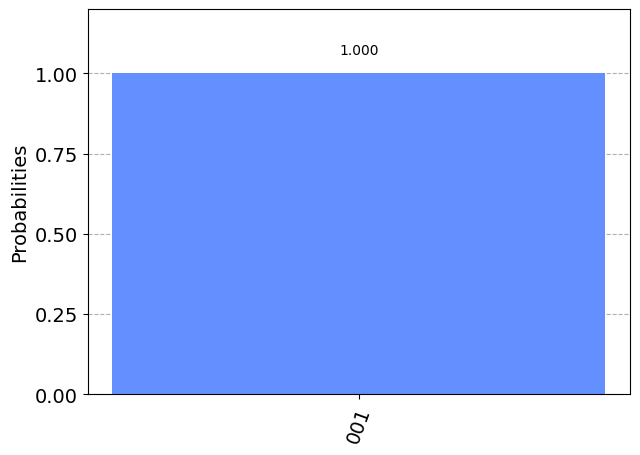

In [14]:
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe)
#히스토그램으로 표시
plot_histogram(answer)

이론과 동일하게 위상은 0*(0.5)+0*(0.25)+1*(0.125)=0.125으로 관측되어진다.

## Real Device

사용할 수 있는 양자 컴퓨터들의 정보는 IBM 양자계산 홈페이지(https://quantum-computing.ibm.com/services?systems=yours)에서 확인할 수 있다. 수업에서 우선 순위로 제공받은 양자 컴퓨터들은 아래의 5가지이다:

    -ibmq_bogota      ( 5 qubits, 32 quantum volume)
    -ibmq_casablanca  ( 7 qubits, 32 quantum volume)
    -ibmq_jakarta     ( 7 qubits, 16 quantum volume)
    -ibmq_rome        ( 5 qubits, 32 quantum volume)
    -ibmq_toronto     (27 qubits, 32 quantum volume)

In [15]:
provider=IBMQ.get_provider(hub='ibm-q-skku', group='internal', project='reservations')

In [16]:
for backend in provider.backends():
        print(backend)

ibmq_rome
ibmq_toronto
ibmq_bogota
ibmq_casablanca
ibmq_jakarta


In [16]:
nqubits = 4
backend_real = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend_real)

#directly select backend
#system = provider.get_backend('ibmq_bogota')
backend_real

least busy backend:  ibmq_jakarta


<IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>

In [17]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe, backend_real)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_real.run(qobj)
#작업 진행 과정 표시
job_monitor(job)

<ipython-input-17-f5c16d0019b7>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend_real.run(qobj)


Job Status: job has successfully run


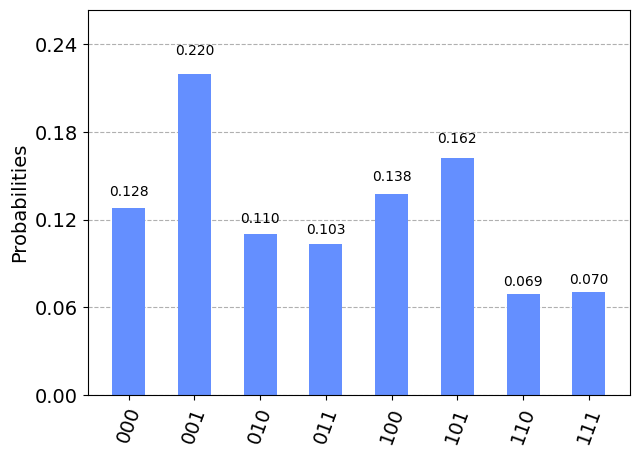

In [18]:
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe)
#히스토그램으로 표시
plot_histogram(answer)

2021-06-14 23:52 에 'ibmq_bogota'를 이용하여 얻어놓은 데이터는 아래와 같습니다.

In [17]:
provider=IBMQ.get_provider(hub='ibm-q-skku', group='internal', project='reservations')

backend_bogota= provider.get_backend('ibmq_bogota')
backend_bogota

<IBMQBackend('ibmq_bogota') from IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>

In [18]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe, backend_bogota)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_bogota.run(qobj)
#작업 진행 과정 표시
job_monitor(job)

<ipython-input-18-36e3b57e85f3>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend_bogota.run(qobj)


Job Status: job has successfully run


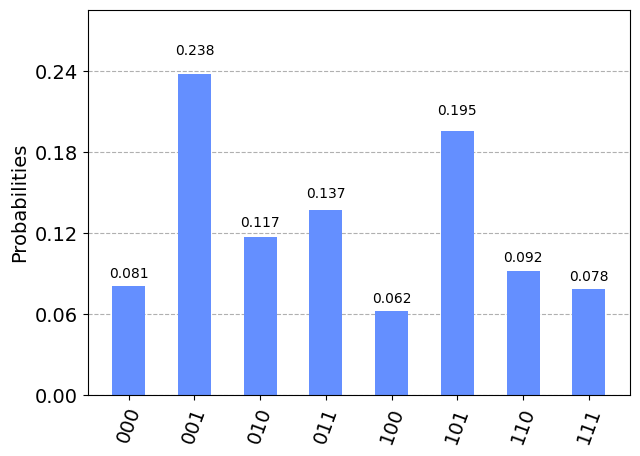

In [19]:
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe)
#히스토그램으로 표시
plot_histogram(answer)

이제 구하고자하는 행렬 또는 전체 큐빗 개수를 바꿔가며 여러가지 시도를 해보자.

In [20]:
provider=IBMQ.get_provider(hub='ibm-q-skku', group='internal', project='reservations')

backend_jakarta= provider.get_backend('ibmq_jakarta')
backend_jakarta

<IBMQBackend('ibmq_jakarta') from IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>

In [21]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe, backend_jakarta)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_jakarta.run(qobj)
#작업 진행 과정 표시
job_monitor(job)

<ipython-input-21-771fb9768d45>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend_jakarta.run(qobj)


Job Status: job has successfully run


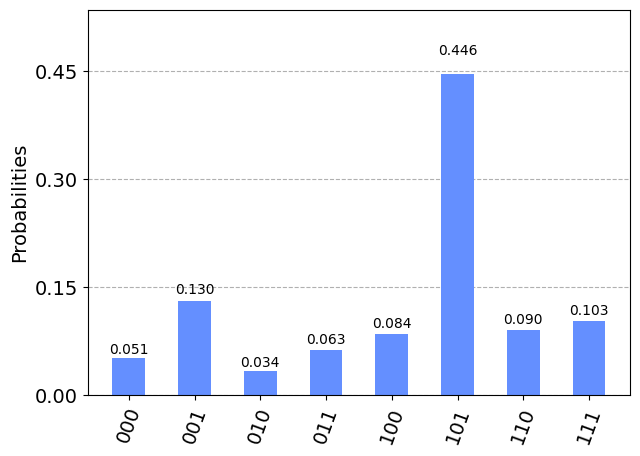

In [22]:
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe)
#히스토그램으로 표시
plot_histogram(answer)

In [26]:
# 큐빗 개수
qn=10
# 고전 비트 개수
mn=qn-1
# 회로 생성
qpe_lot = QuantumCircuit(qn,mn)

# 하다마드 게이트 연결
for qubit in range(mn):
    qpe_lot.h(qubit)

# 초기상태 준비를 위해 x 게이트 연결
qpe_lot.x(mn)

# 각각의 큐빗들이 자릿수가 올바르게 의미가 되도록 컨트롤 U 게이트들 연결
angle = 1*math.pi/4
repetitions = 1
for counting_qubit in range(mn):
    for i in range(repetitions):
        qpe_lot.cp(angle, counting_qubit, mn );
    repetitions *= 2

# 푸리에 역변환 회로 연결
qft_dagger(qpe_lot, mn)

# 관측 연결
qpe_lot.barrier()
for n in range(mn):
    qpe_lot.measure(n,n)

## Simulation

In [27]:
provider=IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_sim = provider.get_backend('ibmq_qasm_simulator')
backend_sim

<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>

Job Status: job has successfully run


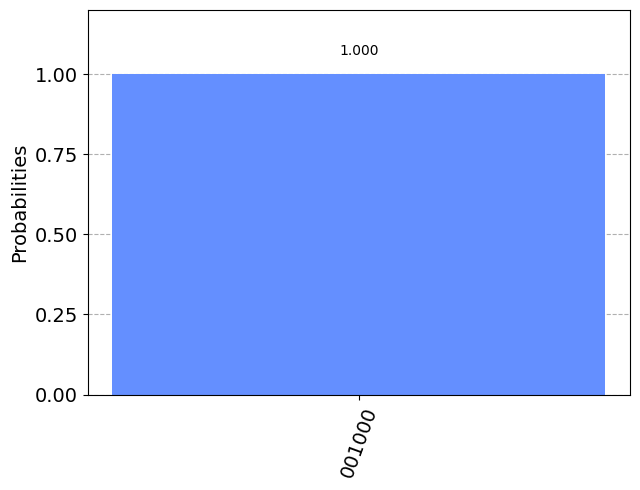

In [29]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe_lot, backend_sim)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_sim.run(qobj)
#작업 진행 과정 표시
job_monitor(job)
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe_lot)
#히스토그램으로 표시
plot_histogram(answer)

## Real Device

In [28]:
provider=IBMQ.get_provider(hub='ibm-q-skku', group='internal', project='reservations')

backend_toronto= provider.get_backend('ibmq_toronto')
backend_toronto

<IBMQBackend('ibmq_toronto') from IBMQ(hub='ibm-q-skku', group='internal', project='reservations')>

In [29]:
# 같은 회로로 실행할 총 횟수 설정
shots = 2048
# 회로 코드를 선택한 장비의 언어로 변환
t_qpe = transpile(qpe_lot, backend_toronto)
#변환된 코드를 장비에 입력
qobj = assemble(t_qpe, shots=shots)
#작업 실행
job = backend_toronto.run(qobj)
#작업 진행 과정 표시
job_monitor(job)

<ipython-input-29-7f00afd99fff>:8: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend_toronto.run(qobj)


Job Status: job has successfully run


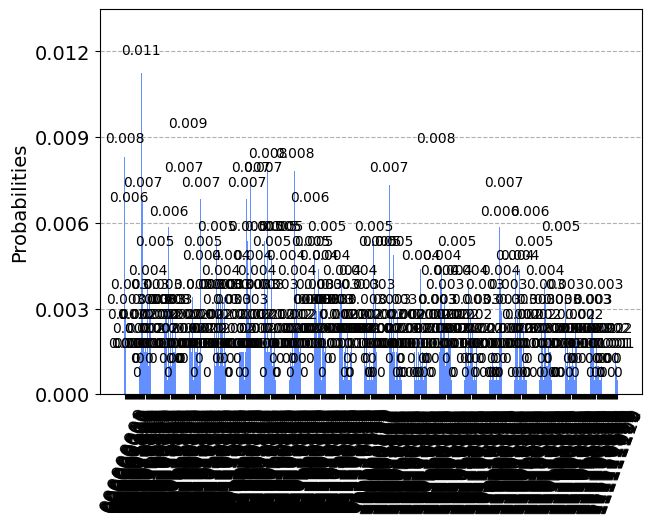

In [30]:
#측정 결과값 출력
results = job.result()
#개수로 변환
answer = results.get_counts(qpe_lot)
answer
#히스토그램으로 표시
plot_histogram(answer)

In [31]:
answer

{'000000000': 17,
 '000000001': 6,
 '000010000': 23,
 '100000000': 11,
 '100000001': 4,
 '100000010': 7,
 '100000011': 3,
 '100000100': 10,
 '100000101': 5,
 '100000110': 3,
 '100000111': 1,
 '100001000': 10,
 '100001001': 4,
 '100001010': 4,
 '100001011': 3,
 '100001100': 5,
 '100001101': 3,
 '100001110': 2,
 '000010001': 14,
 '100010000': 15,
 '100010001': 4,
 '100010010': 6,
 '100010011': 3,
 '100010100': 10,
 '100010101': 3,
 '100010110': 1,
 '100010111': 3,
 '100011000': 6,
 '100011001': 1,
 '100011010': 2,
 '100011011': 2,
 '100011100': 1,
 '100011101': 4,
 '100011110': 1,
 '000010010': 4,
 '100100000': 5,
 '100100001': 5,
 '100100010': 5,
 '100100011': 1,
 '100100100': 3,
 '100100101': 2,
 '100100110': 4,
 '100100111': 1,
 '100101000': 4,
 '100101001': 3,
 '100101011': 1,
 '100101100': 4,
 '100101101': 1,
 '100101110': 3,
 '100101111': 1,
 '000010011': 3,
 '100110000': 9,
 '100110001': 2,
 '100110010': 3,
 '100110011': 1,
 '100110100': 2,
 '100110101': 2,
 '100110110': 3,
 '1001

### Reference

[1] https://quantum-computing.ibm.com/lab/docs/iql/manage/systems/

[2] https://github.com/Qiskit/ibmq-device-information/tree/master/backends/yorktown/V1

[3] https://qiskit.org/textbook/ch-algorithms/quantum-phase-estimation.html